## Homework_2023_04_27 图像处理进阶（二）
教师：胡俊峰

助教：李一飞 朱成轩

本次作业总分为10分

## 引言

**太长不看版：这次作业主要以阅读学习为主，代码负担较轻。希望大家认真完成期中大作业！**

本次课程的主要内容是Hough变换、离散余弦变换和离散傅里叶变换。课程的重点是理解这些算法的原理，可以结合胡老师课上的讲解、课件中的内容以及网上的资料来学习。

其中Hough变换大家在上次作业中已经动手实践过，本次作业就不再布置。希望大家配合这节课堂上对原理的讲解，更好地理解整个算法。

对于DCT、DFT而言，相比于理解算法的思想，代码实现则相对简单，只需调用相应接口即可；重要的是理解输入输出的含义以及变换的过程。

为了减轻同学们做期中大作业的负担，本次作业的主要目标是阅读代码并消化理解知识点，同时完成一些基本功能的实现即可。

### 参考资料
这里列举了一些个人觉得还不错的参考资料供大家学习理解：

[OpenCV中文文档——Hough变换](https://opencv-python-tutorials.readthedocs.io/zh/latest/4.%20OpenCV%E4%B8%AD%E7%9A%84%E5%9B%BE%E5%83%8F%E5%A4%84%E7%90%86/4.13.%20%E9%9C%8D%E5%A4%AB%E7%BA%BF%E5%8F%98%E6%8D%A2/)

[通俗易懂的理解傅里叶变换（一）](https://zhuanlan.zhihu.com/p/317237264)

[OpenCV中文文档——傅里叶变换](https://opencv-python-tutorials.readthedocs.io/zh/latest/4.%20OpenCV%E4%B8%AD%E7%9A%84%E5%9B%BE%E5%83%8F%E5%A4%84%E7%90%86/4.11.1%20%E5%82%85%E9%87%8C%E5%8F%B6%E5%8F%98%E6%8D%A2/)

## 第零部分，请认真阅读代码，理解代码的功能

这一部分中，助教将具体展示JPEG压缩的几个步骤。

In [1]:
import numpy as np
from scipy.fft import dctn,idctn
from matplotlib import pyplot as plt

首先，回顾一下对8*8的图片做DCT时会用到的64个基。对于DCT(Discrete Cosine Transformation)和IDCT(Inverse Discrete Cosine Transformation)，我们使用spicy.fft包的实现。通过指定做IDCT的为特定位置是1、其它位置均是0的矩阵，我们可以把基表示出来。

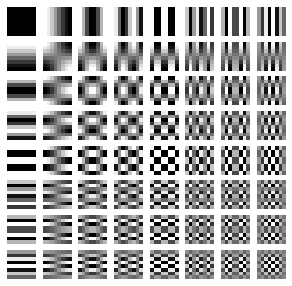

In [2]:
plt.figure(figsize=(5,5))
a = np.zeros((8,8))
for i in range(8):
    for j in range(8):
        a[i, j] = 1
        plt.subplot(8,8,i*8+j+1)
        plt.axis("off")
        plt.imshow(idctn(a),'gray')
        a[i, j] = 0

plt.show()

常见图片压缩软件将图片压缩为JPEG时，可以指定保存图片的“质量”（取值0~100）。接下来的两个代码块中，您将详细了解JPEG压缩过程中是如何减少高频信息，从而利用了人眼对低频信息更敏感的特点。

In [3]:
table_base = np.array([
    [16, 11, 10, 16, 24, 40, 51, 61],
    [12, 12, 14, 19, 26, 58, 60, 55],
    [14, 13, 16, 24, 40, 57, 69, 56],
    [14, 17, 22, 29, 51, 87, 80, 62],
    [18, 22, 37, 56, 68, 109, 103, 77],
    [24, 35, 55, 64, 81, 104, 113, 92],
    [49, 64, 78, 87, 103, 121, 120, 101],
    [72, 92, 95, 98, 112, 100, 103, 99]])

def get_quantization_mat(quality=50):
    S = (5000/quality) if (quality<50) else (200-2*quality)
    Q_mat = np.floor((S*table_base + 50) / 100).clip(min=1)
    return Q_mat

compress()函数中，compressed对象保存的是可以用于存成文件的中间结果。当这一中间结果的信息量（熵）——或者说，取值情况较少（例如在高频的部分由于quantization而有很多元素为0），拿来做压缩后的文件大小也会减少。

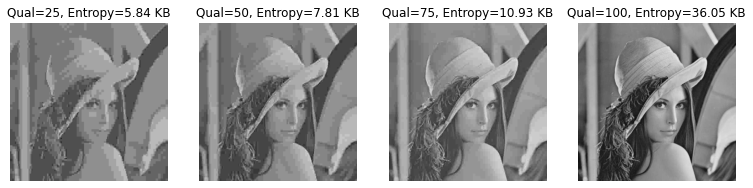

In [4]:
import cv2
lena_bw = cv2.imread('lena.jpg',0)/255.
def compress(img, quality=50):
    result = np.zeros_like(img)
    Q_mat = get_quantization_mat(quality)
    assert img.shape[0] % 8 == 0 and img.shape[1] % 8 == 0
    record = []
    for i in range(0,img.shape[0],8):
        for j in range(0,img.shape[1],8):
            compressed = np.round(dctn(img[i:i+8,j:j+8]) / Q_mat).astype('int')
            record.append(compressed.ravel())
            result[i:i+8,j:j+8] = idctn(compressed * Q_mat)
    record = np.concatenate(record)
    count = np.bincount(record-record.min()).astype('float')
    count /= np.sum(count)
    entropy = np.sum(-count * np.log2(count,where=count>0))
    return result, entropy

plt.figure(figsize=(13,3))
for i,quality in enumerate([25,50,75,100]):
    plt.subplot(1,4,i+1)
    plt.axis("off")
    new_img, entropy = compress(lena_bw,quality)
    plt.imshow(new_img,'gray')
    plt.title(f'Qual={quality}, Entropy={entropy*lena_bw.size/8192:.2f} KB')

## 第一部分：线性回归和多项式回归、离散余弦变换（DCT）、离散傅里叶变换（DFT）

### 1.1 线性回归和多项式回归（共4分）

#### 1.1.1 使用sklearn的相关函数实现对数据点的**线性回归**，用散点图展示出数据样本点，并画出拟合直线、计算均方误差（2分）

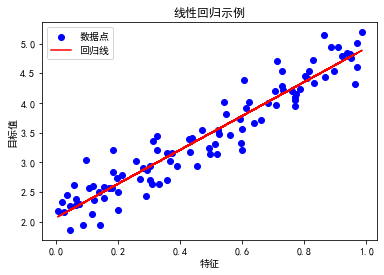

均方误差: 0.07


In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置中文字体


# 0. 设置随机数种子以便于结果可复现
np.random.seed(42)


# 1. 随机生成数据
n_samples = 100
X = np.random.rand(n_samples, 1)
y = 3 * X + 2 + np.random.randn(n_samples, 1) * 0.3  # 添加噪声项


# 2. 拟合线性回归（0.5分）
# TODO
model = None


# 3. 预测（0.5分）
y_pred = None


# 4. 绘制散点图和回归线（0.5分）
# TODO
plt.scatter()
plt.plot()
plt.xlabel('特征')
plt.ylabel('目标值')
plt.legend()
plt.title('线性回归示例')
plt.show()


# 5. 计算均方误差（0.5分）
# TODO
mse = None
print(f"均方误差: {mse:.2f}")

#### 1.1.2 使用sklearn的相关函数实现对数据点的**多项式回归**，用散点图展示出数据样本点，并画出拟合曲线、计算均方误差（2分）

均方误差: 0.01


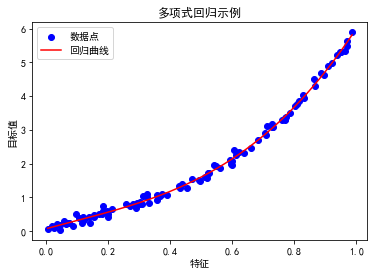

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error


# 0. 设置随机数种子以便于结果可复现
np.random.seed(42)


# 1. 随机生成数据（三次函数+噪声）
n_samples = 100
X = np.random.rand(n_samples, 1)
y = 5 * X**3 - 2 * X**2 + 3 * X + np.random.randn(n_samples, 1) * 0.1


# 2. 按照三次函数创建多项式特征（0.5分）
# TODO
poly_features = None
X_poly = None


# 3. 对多项式特征再拟合一个线性回归（0.5分）
# TODO
model = None


# 4. 预测（0.5分）
# TODO
y_pred = None


# 5. 计算均方误差（0.5分）
# TODO
mse = None
print(f"均方误差: {mse:.2f}")


# 6. 绘制散点图和回归曲线
plt.scatter(X, y, label='数据点', color='blue')
X_plot = np.linspace(X.min(), X.max(), 500).reshape(-1, 1)
X_plot_poly = poly_features.transform(X_plot)
y_plot = model.predict(X_plot_poly)
plt.plot(X_plot, y_plot, label='回归曲线', color='red')
plt.xlabel('特征')
plt.ylabel('目标值')
plt.legend()
plt.title('多项式回归示例')
plt.show()

### 1.2 使用DFT+高通/低通滤波（共6分）

网上关于傅里叶变换的教程很多，这里就不再赘述，感兴趣的同学可以阅读这个博客帮助理解：[通俗易懂的理解傅里叶变换（一）](https://zhuanlan.zhihu.com/p/317237264)

通俗一点讲，**傅里叶变换**可以理解成对同一个事物观看角度的变化————不再从时域，而是从频域对目标信号进行观看。关于时域和频域信号的理解也可以参考上面这个博客。

傅里叶变换的应用极其广泛，主要是因为它能够将一个信号或图像分解为一系列频率分量，从而更好地理解和处理信号或图像的特性。

使用高通滤波器之后，会保留高频信息，增强图像细节，例如边界增强；

使用低通滤波器之后，会保留低频信息，边界模糊。

本次作业会引导大家使用numpy和opencv库对图片应用傅里叶变换进行简单的高通/低通滤波，观察对图片产生的影响。

#### 首先来看一个使用numpy.fft实现快速傅里叶变换的例子：

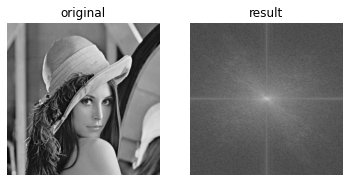

In [6]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

# 读取图片
img = cv.imread('lena.jpg', 0)

# 快速傅里叶变换算法得到频率分布，将空间域转化为频率域
f = np.fft.fft2(img)

# 默认结果中心点位置是在左上角,通过下述代码将中心点转移到中间位置
# 将低频部分移动到图像中心
fshift = np.fft.fftshift(f)

# fft 结果是复数, 其绝对值结果是振幅
result = 20*np.log(np.abs(fshift))

plt.subplot(121)
plt.imshow(img, cmap='gray')
plt.title('original')
plt.axis('off')

plt.subplot(122)
plt.imshow(result, cmap='gray')
plt.title('result')
plt.axis('off')

plt.show()

可以看到，左边的输出是原始灰度图像，右边的输出是频率分布图谱。其越靠近中心位置频率越低，灰度值越高亮度越亮的中心位置代表该频率的信号振幅越大。

想要恢复原始图片，需要将其进行逆变换，也就是反向操作回去，将频谱图像转换为原始图像。

#### 1.2.1 下面是实现傅里叶变换和逆变换的完整代码。请调用接口，补全其中的信号移动和傅里叶变换的正/逆操作（2分）：

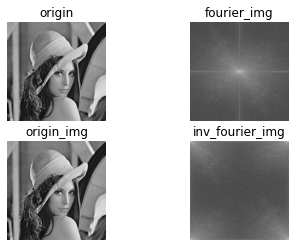

In [7]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt


# 0. 读取图片
img = cv.imread("lena.jpg", 0)


# 1. 对图片进行傅里叶变换（0.5分）
img_fft = None


# 2. 将低频部分移动到图像中心（0.5分）
# TODO
img_fft_shifted = None
# 将复数转为浮点数进行傅里叶频谱图显示
img_fft_shifted_float = np.log(np.abs(img_fft_shifted))


# 3. 信号移动操作的逆操作（0.5分）
# TODO
img_fft_inv_shifted = None
# 将复数转为浮点数进行傅里叶频谱图显示
img_fft_inv_shifted_float = np.log(np.abs(img_fft_inv_shifted))


# 4. 恢复原始图片（0.5分）
# TODO
img_ifft = None
origin_img = np.abs(img_ifft)


# 5. 显示结果
plt.subplot(221), plt.imshow(img, "gray"), plt.title('origin')
plt.axis('off')
plt.subplot(222), plt.imshow(img_fft_shifted_float, "gray"), plt.title('fourier_img')
plt.axis('off')
plt.subplot(223), plt.imshow(origin_img, "gray"), plt.title('origin_img')
plt.axis('off')
plt.subplot(224), plt.imshow(img_fft_inv_shifted_float, "gray"), plt.title('inv_fourier_img')
plt.axis('off')
plt.show()

执行了以上过程之后，你应该对傅里叶变换的过程有了一定的了解。为了更好地理解对频域信号进行处理的作用，我们将对其进行一个高通/低通滤波操作。

高通和低通滤波都是信号或图像处理中常用的滤波操作，它们的主要目的是通过去除或弱化某些频率分量来改变信号或图像的特性。

低通滤波是指滤除高频成分，只保留低频成分的滤波方式。低通滤波器的通带范围是0到截止频率，截止频率以上的高频成分被滤除，而截止频率以下的低频成分则保留。因此，低通滤波器主要用于平滑图像、去除噪声、提取低频特征等方面。常见的低通滤波器有均值滤波器、高斯滤波器等。

高通滤波是指滤除低频成分，只保留高频成分的滤波方式。高通滤波器的通带范围是截止频率到无限大，截止频率以下的低频成分被滤除，而截止频率以上的高频成分则保留。因此，高通滤波器主要用于增强图像的细节、锐化图像、去除低频背景等方面。常见的高通滤波器有拉普拉斯滤波器、Sobel算子等。

#### 1.2.2 在上一段代码的基础上，让我们对DFT之后的频域图片信号加入低通、高通滤波操作，并观察效果（4分）：

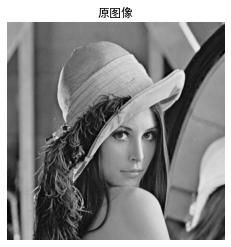

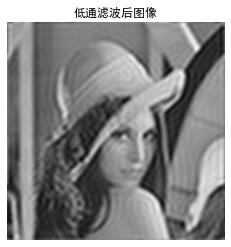

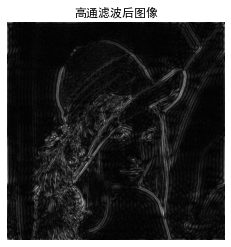

In [8]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置中文字体

# 0. 读取图片
img = cv.imread("lena.jpg", 0)


# 1. 进行傅里叶变换
f = np.fft.fft2(img)
fshift = np.fft.fftshift(f)


# 2. 实现低通滤波（2分）
# 制定低通滤波矩阵mask_low，大小和图像一样，中间方形为1，其余为0
# 目标：使图片正中心位置的上下左右各30个像素的低频信号通过，其余信号被屏蔽
# 定义mask_low矩阵后，与fshift进行运算，得到fshift_low
# TODO
mask_low = None
fshift_low = None


# 3. 实现高通滤波（2分）
# 制定高通滤波矩阵mask_high，大小和图像一样，中间方形为0，其余为1
# 目标：使图片正中心位置的上下左右各30个像素的低频信号被屏蔽，其余高频信号通过
# 定义mask_high矩阵后，与fshift进行运算，得到fshift_high
# TODO
mask_high = None
fshift_high = None


# 4. 逆傅里叶变换恢复图片
ifshift_low = np.fft.ifftshift(fshift_low)
ifshift_high = np.fft.ifftshift(fshift_high)
# 将复数转为浮点数进行傅里叶频谱图显示
ifimg_low = np.fft.ifft2(ifshift_low)
ifimg_high = np.fft.ifft2(ifshift_high)
dft_img_low = np.abs(ifimg_low)
dft_img_high = np.abs(ifimg_high)


# 图像显示
plt.imshow(img, 'gray'), plt.title('原图像'), plt.axis('off'), plt.show()
plt.imshow(dft_img_low, 'gray'), plt.title('低通滤波后图像'), plt.axis('off'), plt.show()
plt.imshow(dft_img_high, 'gray'), plt.title('高通滤波后图像'), plt.axis('off')
plt.show()

### 1.2.3 OpenCV实现DFT+低通/高通滤波（阅读即可）

流程跟上述过程类似，只是换成了用opencv库来实现。为了减轻同学们的代码负担，此部分直接给出，大家自行阅读并查询API用法即可。

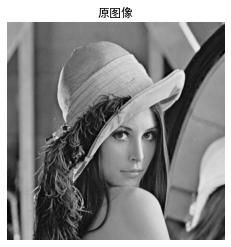

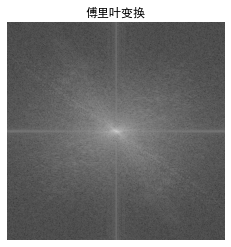

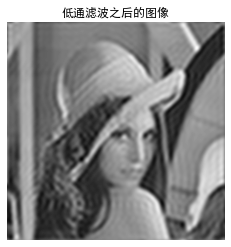

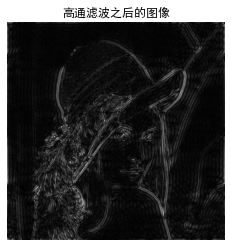

In [9]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置中文字体

# 0. 读取图片
img = cv.imread("lena.jpg", 0)

# OpneCV傅里叶变换函数
# 需要将图像进行一次float转换
result = cv.dft(np.float32(img), flags=cv.DFT_COMPLEX_OUTPUT)
# 将频谱低频从左上角移动至中心位置
dft_shift = np.fft.fftshift(result)
# 频谱图像双通道复数转换为 0-255 区间
result = 20 * np.log(cv.magnitude(dft_shift[:, :, 0], dft_shift[:, :, 1]))

rows, cols = img.shape
crow, ccol = rows//2, cols//2

# 定义低通滤波的mask矩阵
mask_low = np.zeros((rows, cols, 2), np.uint8)
# 设定图片正中间的30*30的区域作为滤波区域
mask_low[int(crow-30):int(crow+30), int(ccol-30):int(ccol+30)] = 1

# 定义高通滤波的mask矩阵
mask_high = np.ones((rows, cols, 2), np.uint8)
# 设定图片正中间的30*30的区域作为滤波区域
mask_high[crow-30:crow+30, ccol-30:ccol+30] = 0

# LPF（Low-Pass Filter，低通滤波）
fshift_low = dft_shift*mask_low
f_ishift_low = np.fft.ifftshift(fshift_low)
img_lpf = cv.idft(f_ishift_low)
img_lpf = cv.magnitude(img_lpf[:, :, 0], img_lpf[:, :, 1])

#  HPF（High-Pass Filter，高通滤波）
fshift_high = dft_shift*mask_high
f_ishift_high = np.fft.ifftshift(fshift_high)
img_hpf = cv.idft(f_ishift_high)
img_hpf = cv.magnitude(img_hpf[:, :, 0], img_hpf[:, :, 1])


# 显示图像
plt.imshow(img, 'gray'), plt.title('原图像'), plt.axis('off'), plt.show()
plt.imshow(result, 'gray'), plt.title('傅里叶变换'), plt.axis('off'), plt.show()
plt.imshow(img_lpf, 'gray'), plt.title('低通滤波之后的图像'), plt.axis('off'), plt.show()
plt.imshow(img_hpf, 'gray'), plt.title('高通滤波之后的图像'), plt.axis('off')
plt.show()